In [1]:
#import packages
import os
from time import sleep
import matplotlib

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

font = {'family' : 'Arial',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
import numpy as np
import qcodes as qc
from qcodes import (
    Measurement,
    experiments,
    initialise_database,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_experiment,
    load_last_experiment,
    load_or_create_experiment,
    new_experiment,
)
from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging

from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.plotting import plot_2d_scatterplot
import pickle
import matplotlib.animation as animation

from  matplotlib.animation import FFMpegWriter


colormap='viridis'

In [2]:
def id_plot(database, run_id, title="",vmin=-0.003,vmax=0.2, directory='C:/Users/NE-admin/Jupyter analysis/'):
    
    database=database
    initialise_or_create_database_at(f"D:/meas_dbs/Amber/{database}/db_{database}.db")

    matplot = plot_by_id(run_id, cmap=colormap,vmin=vmin,vmax=vmax)[0][-1];
    plt.close('all')

    matplot.set_title(title+'\n'+f'#{database}- {run_id}')

    fig1 = matplot.figure
    fig1.set_tight_layout(True)

    fig1.show()
    fig1.savefig(directory+title+f'{database} -{run_id}.png', dpi=150)
    return fig1

In [618]:
database=20201208
run_id = 10

initialise_or_create_database_at(f"D:/meas_dbs/Antonio/{database}/db_{database}.db")


dataset_10 = load_by_id(run_id)
dataset_11 = load_by_id(11)

offset = -0.00025

data10_xarray=dataset_10.to_xarray_dataset()
#data_xarray=dataset.to_xarray_datarray_dict()

RB=data10_xarray['ivvi_RB'].values
LB=data10_xarray['ivvi_LB'].values
#data=np.transpose(data_xarray['keith1_Idc1'].values)
data_rid10=data10_xarray['keith1_Idc1'].values - offset

LB=np.append(LB,LB[len(LB)-1]+(LB[len(LB)-1]-LB[len(LB)-2]))
RB=np.append(RB,RB[len(RB)-1]+(RB[len(RB)-1]-RB[len(RB)-2]))
X10, Y10 = np.meshgrid(RB,LB)

# data=data_rid10

fig, axs = plt.subplots(1, 2)
cf = axs[0].pcolormesh(X10,Y10,data_rid10, shading='flat', vmin = -4e-3,vmax = 4e-3) #vmin = -0.4e-3,vmax = 2e-3)# vmax = 32767)
axs[0].set_title('V_SD  = 2 mV')





[[-1.87855200e-06  5.23630900e-06  2.77967720e-05 ... -5.01393660e-05
   9.25739070e-05  2.10341966e-04]
 [ 5.62565350e-05  1.33569620e-05  2.95532820e-05 ...  3.45701110e-05
   2.73654000e-06  1.97818702e-04]
 [-2.65966760e-05  4.34026090e-05 -4.25608950e-05 ... -3.05829630e-05
   1.77392220e-05  1.67337196e-04]
 ...
 [-7.28242700e-06  7.46691400e-06 -2.55328230e-05 ...  3.23048400e-06
  -3.16982580e-05  1.66328946e-04]
 [ 2.26910790e-05  4.85909510e-05  5.32721710e-05 ...  1.92852830e-05
   9.81855900e-06  1.47857897e-04]
 [ 4.16229090e-05  3.88679260e-05 -5.43232070e-05 ... -3.38171500e-06
   1.52489208e-04  1.74042360e-04]]


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [497]:
## spin flip cotunneling fit

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def I_cotunneling(x,a,b,c):

    y_cotun = a*b*x/np.sinh(b*x)+c
    return y_cotun
    
def I_so(x,a_so,c_so,d_so):
    y_so = a_so*(1-8/9*c_so**2/(x**2+c_so**2))+d_so
    return y_so

def I_fit(x,a,b,c,a_so,c_so,d_so):
    return I_cotunneling(x,a,b,c)+I_so(x,a_so,c_so,d_so)

# print(sinh(By_all))


bounds_low= [0,                         -1,      -10,         -10,        -5,        -10]
bounds_high= [30*np.max(I_fitted),       10,      10,         5,     5,         0]
# p0=[ 4.02131267e-13,  2.33848412e+00,  -0.48610727e-13, 1.17781150e-13,-0.64035630,-0.01e-11]
p0=[ 5.49654113,  0.41310143, -5.3, 0.099998742, 0.199979628, 0]
# I_fitted=I_fitted*1e-9
parameters, covariance = curve_fit(I_fit, By_all[1:], I_fitted[1:],p0=p0, maxfev=1000000,bounds=(bounds_low,bounds_high))#,bounds=(fit_bounds_low,fit_bounds_high))
# parameters, covariance = curve_fit(I_fit, By_all[1:], I_fitted[1:], maxfev=10000,bounds=(bounds_low,bounds_high))#,bounds=(fit_bounds_low,fit_bounds_high))


print(30*np.max(I_fitted))
print(parameters)

# parameters=[ 3.25935893e-13, 4,  0.5e-13, -15e-14, 8.92613717e-,-1e-7]

# parameters=[ 0.53205872e0,  60.70604540e-01, -0.1573088e+00,  1.08396861e-01, 3.98799865e-01, -4.14061627e-07]
fit_cotun=I_fit(By_all,*parameters)

figure = plt.figure()

i2=plt.plot(By_all,I_fitted,'o')
i3=plt.plot(By_all,fit_cotun)
i4=plt.plot(By_all,I_cotunneling(By_all,*parameters[0:3]),By_all,I_so(By_all,*parameters[3:6]))


plt.show()

8.054711490628415
[ 5.47490365e+00  6.05226498e-01 -5.25880230e+00  9.83199119e-02
  3.46040517e-01 -2.02599719e-07]


Quantities extracted from fit of co-tunnelling leakage current:

Fitted tunnel rates to S and D, from parameter [0] (prop. to co-tunneling coefficient):
Γ_R = 155.7946696401581 ueV
Γ_L = 38.948667410039526 ueV
Background current, from parameter [2]
I_B = -5.2588022998396715 pA
we can use the relation of eΓ_SO ~ I_B to estimate Γ_SO
Γ_SO = 136.11259390131903 neV

Quantities extracted from fit of SO leakage current:

Spin relaxation rate, from parameter [4]:
gamma_rel=0.5406883077414095 MHz


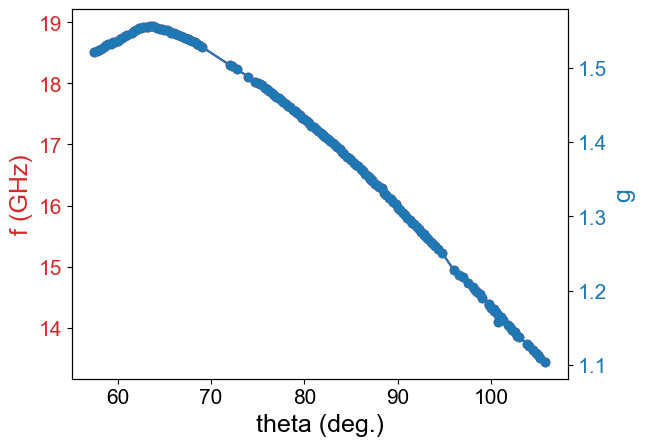

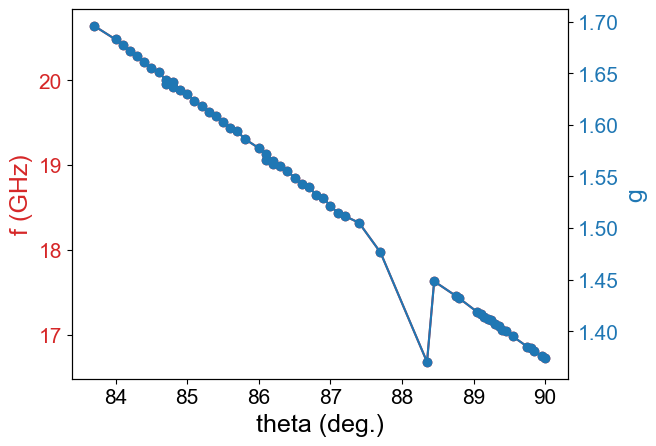

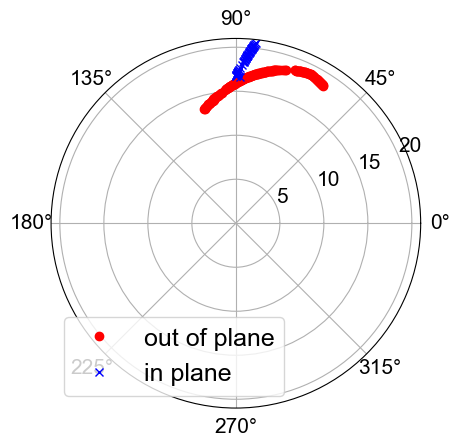